<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/vits/SigLip_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!curl -L http://i.imgur.com/8o9DXSj.jpeg --output image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 44094  100 44094    0     0    98k      0 --:--:-- --:--:-- --:--:--  406k


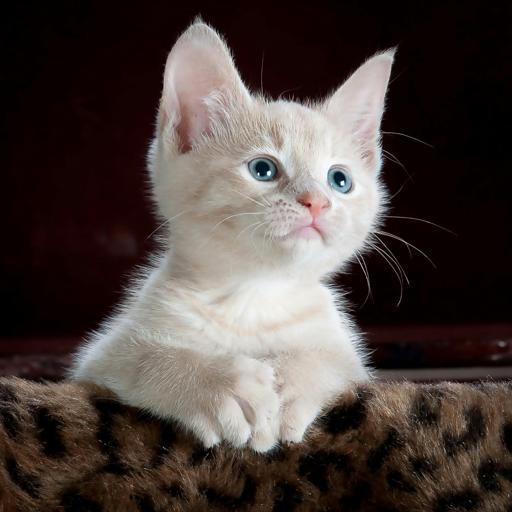

In [4]:
from PIL import Image

img = Image.open("image.jpg")
img

In [5]:
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))

vision_model

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=Tr

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
from torchvision import transforms

In [7]:
def preprocess_image(image, image_size=224):
  preprocess = transforms.Compose([
      transforms.Resize((image_size, image_size)),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )
  ])

  image_tensor = preprocess(image)
  # (3, 224, 244) -> unsqueeze -> (1, 3, 224, 224)
  image_tensor = image_tensor.unsqueeze(0)

  return image_tensor

In [8]:
image_tensor = preprocess_image(img)

embed_dim = 768
patch_size = 15
image_size = 224
num_patches = (image_size // patch_size) ** 2

with torch.no_grad():
  patch_embedding = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
  patches = patch_embedding(image_tensor)

patches.shape, num_patches

(torch.Size([1, 768, 14, 14]), 196)

In [9]:
position_embedding = nn.Embedding(num_patches, embed_dim)
position_ids = torch.arange(num_patches).expand(1, -1)
position_ids.shape

torch.Size([1, 196])

In [10]:
# after flatten (1, 768, 196)
embeddings = patches.flatten(start_dim=2, end_dim=-1)
# (1, 768, 196) -> (1, 196, 768)
embeddings = embeddings.transpose(1,2)
embeddings = embeddings + position_embedding(position_ids)
embeddings.shape

torch.Size([1, 196, 768])

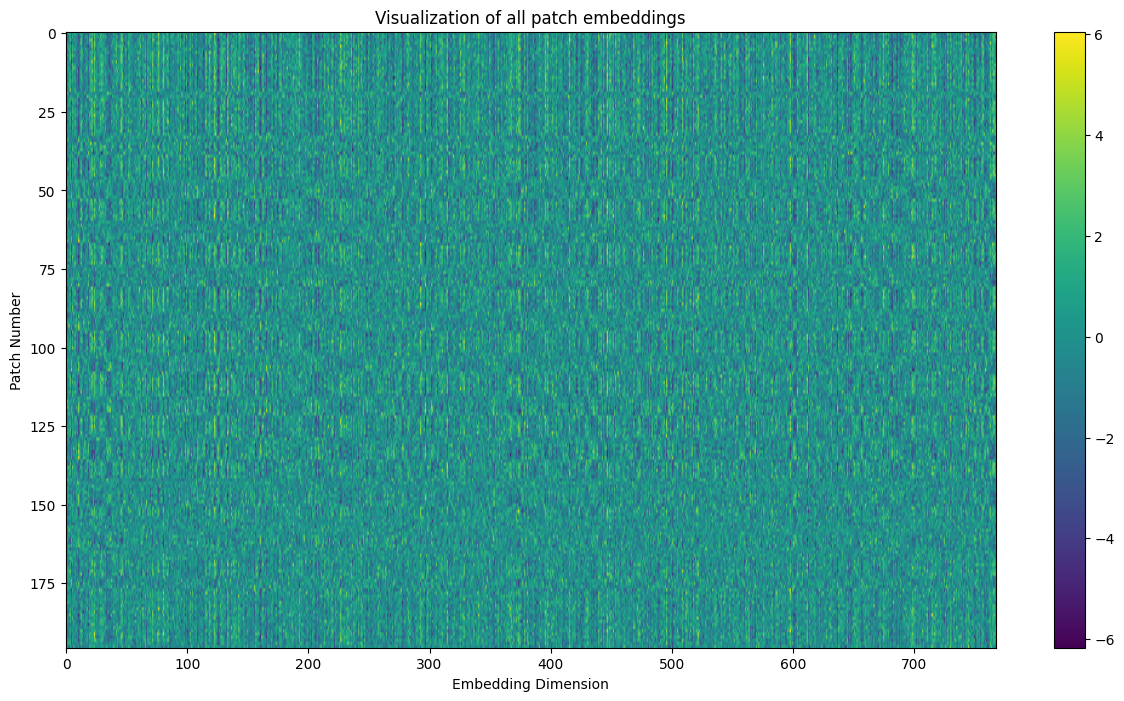

In [11]:
import matplotlib.pyplot as plt

# it should look all random, since the weights are random at the initialization
# Visualize all patch embeddings

patches_viz = embeddings[0].detach().numpy() # (196, 768)

plt.figure(figsize=(15,8))
plt.imshow(patches_viz, aspect="auto", cmap="viridis")
plt.colorbar()
plt.title("Visualization of all patch embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Patch Number")
plt.show()

torch.Size([1, 196, 768])


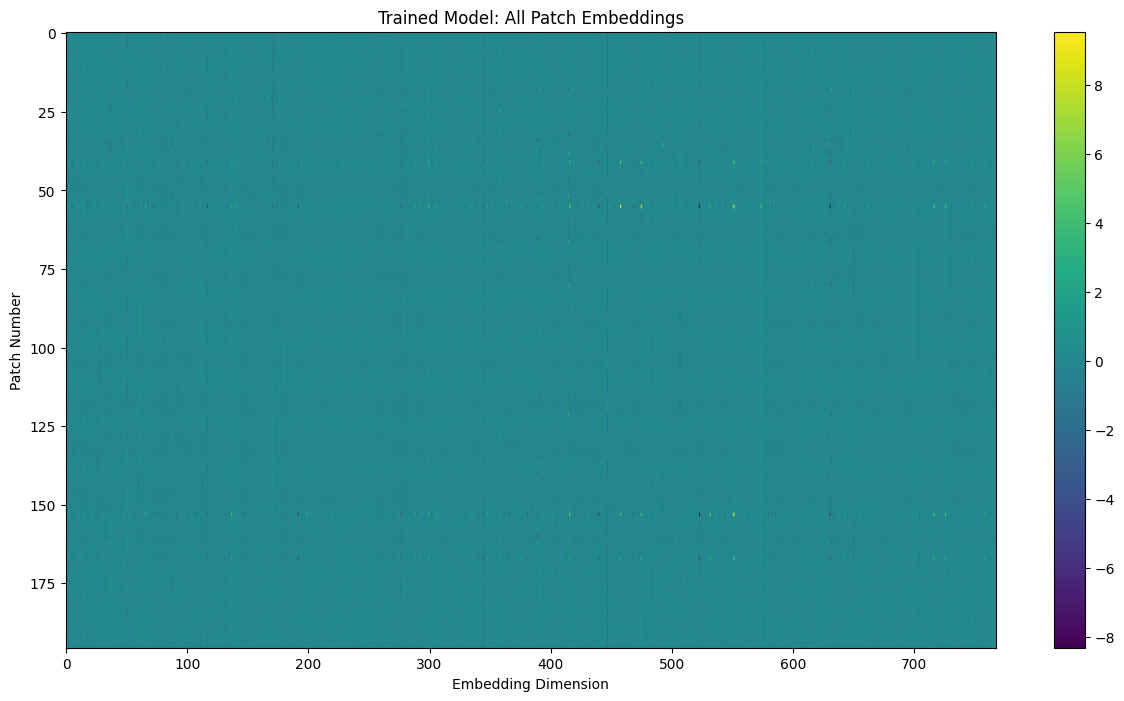

In [12]:
vision_model.eval()
inputs = processor(images=img, return_tensors="pt")
with torch.no_grad():
  patch_embeddings = vision_model.vision_model.embeddings(inputs.pixel_values)

print(patch_embeddings.shape)
patches_viz = patch_embeddings[0].detach().numpy() # (196, 768)

plt.figure(figsize=(15,8))
plt.imshow(patches_viz, aspect="auto", cmap="viridis")
plt.colorbar()
plt.title("Trained Model: All Patch Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Patch Number")
plt.show()

In [13]:
@dataclass
class SiglipVisionConfig:
  num_channels: int = 3
  embed_dim: int = 768
  image_size: int = 224
  patch_size: int = 16

class SiglipVisionEmbeddings(nn.Module):

  def __init__(self, config: SiglipVisionConfig):
    super().__init__()
    self.config = config
    self.num_channels = config.num_channels
    self.embed_dim = config.embed_dim
    self.image_size = config.image_size
    self.patch_size = config.patch_size

    self.patch_embedding = nn.Conv2d(
        in_channels=self.num_channels,
        out_channels=self.embed_dim,
        kernel_size=self.patch_size,
        stride=self.patch_size,
        padding="valid"
    )

    self.num_patches = (self.image_size // self.patch_size) ** 2
    self.num_positions = self.num_patches
    self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
    self.register_buffer(
        "position_ids",
        torch.arange(self.num_positions).expand((1, -1)),
        persistent=False
    )

  def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
    B, C, H, W = pixel_values.shape
    patch_embeds = self.patch_embedding(pixel_values)
    embeddings = patch_embeds.flatten(start_dim=2, end_dim=-1)
    embeddings = embeddings.transpose(1,2)
    embeddings = embeddings + self.position_embedding(self.position_ids)
    return embeddings

In [14]:
embd = SiglipVisionEmbeddings(SiglipVisionConfig())
embd(image_tensor).shape # (1, 196, 768)

torch.Size([1, 196, 768])

In [15]:
from transformers import SiglipVisionModel as HFSiglipVisionModel

our_state_dict = embd.state_dict()
hf_state_dict = {
    k.replace("vision_model.embeddings.", ""): v for k,v in vision_model.state_dict().items()
  if "vision_model.embeddings." in k
}
our_state_dict.update(hf_state_dict)
embd.load_state_dict(our_state_dict)

with torch.no_grad():
  our_output = embd(image_tensor)
  hf_output = vision_model.vision_model.embeddings(image_tensor)
  print("Max difference between our output and HF output:", torch.max(torch.abs(our_output - hf_output)))

Max difference between our output and HF output: tensor(0.)


In [16]:
import math

class Head(nn.Module):
  """ A single head of the multi-head attention """

  def __init__(self, n_in, n_head, context_length):
    super().__init__()
    self.head_size = n_head
    self.key = nn.Linear(n_in, n_head, bias=False)
    self.query = nn.Linear(n_in, n_head, bias=False)
    self.value = nn.Linear(n_in, n_head, bias=False)

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x)
    q = self.query(x)
    v = self.value(x)
    wei = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
    wei = F.softmax(wei, dim=-1)
    out = wei @ v
    return out

class MultiHeadAttention(nn.Module):
  """ Mult-head attention implemenation with concatenating every head's output """
  def __init__(self, num_head, n_in, head_size, context_length):
    super().__init__()
    self.head_size = head_size
    self.num_head = num_head
    self.heads = [Head(n_in, head_size, context_length) for _ in range(num_head)]
    self.proj = nn.Linear(n_in, n_in)

  def forward(self, x):
    out = [h(x) for h in self.heads]
    out = torch.concat(out, -1)
    out = self.proj(out)
    return out

In [17]:
num_attention_heads = 12
hidden_size = 768

attn = MultiHeadAttention(num_head=12, n_in=768, head_size=64, context_length=196)
attn(torch.randn(1, 196, 768))

tensor([[[-0.0127,  0.0303,  0.0160,  ...,  0.0302, -0.0010,  0.0342],
         [-0.0065,  0.0357,  0.0065,  ...,  0.0110,  0.0041,  0.0543],
         [-0.0108,  0.0306,  0.0039,  ...,  0.0220,  0.0134,  0.0451],
         ...,
         [-0.0004,  0.0230, -0.0041,  ...,  0.0094,  0.0174,  0.0561],
         [-0.0040,  0.0227,  0.0013,  ...,  0.0272,  0.0267,  0.0489],
         [-0.0206,  0.0137,  0.0130,  ...,  0.0421,  0.0100,  0.0700]]],
       grad_fn=<ViewBackward0>)

In [25]:
@dataclass
class SiglipVisionConfig:
  num_channels: int = 3
  image_size: int = 224
  patch_size: int = 16
  num_attention_heads: int = 12
  hidden_size: int = 768
  attention_dropout: int = 0.0

class SiglipAttention(nn.Module):

  def __init__(self, config: SiglipVisionConfig):
    super().__init__()
    self.config = config
    self.embed_dim = config.hidden_size
    self.num_heads = config.num_attention_heads
    self.dropout = config.attention_dropout

    self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
    self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
    self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
    self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

  def forward(self, hidden_states):
    # the hidden states are the embeddings if the patches, so (batch_size, num_patches, embed_dim)
    B, T, C = hidden_states.shape
    q_states = self.q_proj(hidden_states)
    k_states = self.k_proj(hidden_states)
    v_states = self.v_proj(hidden_states)

    q_states = q_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1,2)
    k_states = k_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1,2)
    v_states = v_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1,2)

    attn_weights = (q_states @ k_states.transpose(-2, -1)) * (1.0 / math.sqrt(k_states.size(-1)))
    attn_weights = F.softmax(attn_weights, dim=-1).to(q_states.dtype)
    attn_weights = F.dropout(attn_weights, p=self.dropout, training=self.training)

    attn_outs = attn_weights @ v_states
    attn_outs = attn_outs.reshape(B, T, C).contiguous()
    attn_outs = self.out_proj(attn_outs)
    return attn_outs

In [26]:
batch_size = 1
num_patches = 196
embed_dim = 768

hidden_states = torch.randn(batch_size, num_patches, embed_dim)
config = SiglipVisionConfig(
    attention_dropout=0.0,
    num_attention_heads=12,
    hidden_size=768
)
attention = SiglipAttention(config)
output = attention(hidden_states)

print(f"Input shape: {hidden_states.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 196, 768])
Output shape: torch.Size([1, 196, 768])
